In [99]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

This problem is a 5-sat with 5 qubits with one unique solution : 01100
<br>
(x₀ ∨ ¬x₁ ∨ ¬x₂ ∨ ¬x₄) ^ (x₀ ∨ x₁ ∨ ¬x₂) ^ (x₀ ∨ ¬x₁ ∨ x₂) ^ (¬x₀ ∨ x₁ ∨ x₂) ^ (¬x₀ ∨ ¬x₁ ∨ ¬x₂) ^ (x₁ ∨ ¬x₂ ∨ x₃) ^ (¬x₁ ∨ x₂ ∨ x₃) ^ (¬x₁ ∨ ¬x₂ ∨ ¬x₃) ^ (¬x₀ ∨ ¬x₂ ∨ x₃) ^ (¬x₀ ∨ x₂ ∨ ¬x₃) ^ (x₀ ∨ ¬x₂ ∨ ¬x₃) ^ (x₀ ∨ x₂ ∨ x₃) ^ (¬x₀ ∨ ¬x₁ ∨ x₃) ^ (¬x₀ ∨ x₁ ∨ ¬x₃) ^ (x₀ ∨ ¬x₁ ∨ ¬x₃) ^ (x₀ ∨ x₁ ∨ x₃)

In [100]:
num_qubits = 5

In [101]:
from qiskit import QuantumCircuit


def cnot_count(circuit: QuantumCircuit) -> int:
    return circuit.count_ops().get("cx", 0)

In [102]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=5)
parity_ansatz.measure_all()

# parity_ansatz.decompose().draw("mpl")

Parities and Weights of the Hamiltonian:
{'00000': 2.0625, '10000': 0.0625, '01000': -0.0625, '00100': -0.0625, '00001': -0.0625, '11000': -0.0625, '10100': -0.0625, '10001': -0.0625, '01100': 0.0625, '01001': 0.0625, '00101': 0.0625, '11100': -0.4375, '11010': 0.5, '11001': 0.0625, '10110': 0.5, '10101': 0.0625, '01110': -0.5, '01101': -0.0625, '11101': -0.0625}

Forward Circuit with Rz gates:
      ┌─────────────┐                                                     »
q_0: ─┤ Rz(0.125*γ) ├────■──────────────────────■──────────────────────■──»
     ┌┴─────────────┴─┐┌─┴─┐┌────────────────┐  │                      │  »
q_1: ┤ Rz((-0.125)*γ) ├┤ X ├┤ Rz((-0.125)*γ) ├──┼──────────────────────┼──»
     ├────────────────┤└───┘└────────────────┘┌─┴─┐┌────────────────┐  │  »
q_2: ┤ Rz((-0.125)*γ) ├───────────────────────┤ X ├┤ Rz((-0.125)*γ) ├──┼──»
     └────────────────┘                       └───┘└────────────────┘  │  »
q_3: ─────────────────────────────────────────────────────────────────

In [103]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    # Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable.
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [104]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)
print("CNOT count :", cnot_count(parity_ansatz_isa))

SparsePauliOp(['IIIII', 'IIIIZ', 'IIIZI', 'IIZII', 'ZIIII', 'IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'ZIIZI', 'ZIZII', 'IIZZZ', 'IZIZZ', 'ZIIZZ', 'IZZIZ', 'ZIZIZ', 'IZZZI', 'ZIZZI', 'ZIZZZ'],
              coeffs=[ 2.0625+0.j,  0.0625+0.j, -0.0625+0.j, -0.0625+0.j, -0.0625+0.j,
 -0.0625+0.j, -0.0625+0.j, -0.0625+0.j,  0.0625+0.j,  0.0625+0.j,
  0.0625+0.j, -0.4375+0.j,  0.5   +0.j,  0.0625+0.j,  0.5   +0.j,
  0.0625+0.j, -0.5   +0.j, -0.0625+0.j, -0.0625+0.j])
CNOT count : 100


In [105]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["iters"] = 0
    cost_history_dict["cost_history"] = []

In [106]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [107]:
%%time
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 1.85546875
Iters 2: Current cost: 1.2255859375
Iters 3: Current cost: 2.5732421875
Iters 4: Current cost: 2.447265625
Iters 5: Current cost: 2.333984375
Iters 6: Current cost: 2.31640625
Iters 7: Current cost: 1.345703125
Iters 8: Current cost: 1.5146484375
Iters 9: Current cost: 1.560546875
Iters 10: Current cost: 1.0498046875
Iters 11: Current cost: 1.6962890625
Iters 12: Current cost: 2.7841796875
Iters 13: Current cost: 0.5888671875
Iters 14: Current cost: 1.703125
Iters 15: Current cost: 0.4853515625
Iters 16: Current cost: 0.6455078125
Iters 17: Current cost: 0.7197265625
Iters 18: Current cost: 0.4580078125
Iters 19: Current cost: 0.5537109375
Iters 20: Current cost: 0.517578125
Iters 21: Current cost: 0.4833984375
Iters 22: Current cost: 0.443359375
Iters 23: Current cost: 0.3466796875
Iters 24: Current cost: 0.2919921875
Iters 25: Current cost: 0.2705078125
Iters 26: Current cost: 0.2705078125
Iters 27: Current cost: 0.32421875
Iters 28: Current cost: 0.

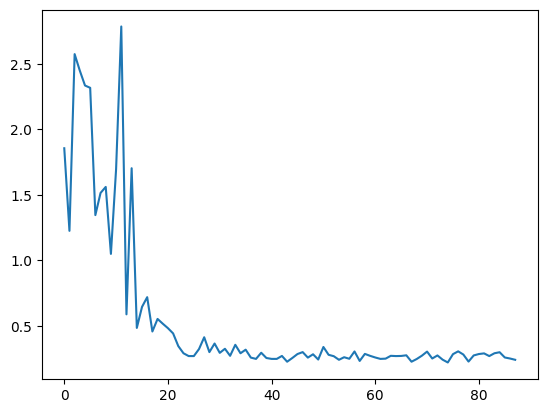

In [108]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

In [109]:
naive_ansatz = QAOAAnsatz(obs, reps=5)
naive_ansatz.measure_all()

# naive_ansatz.decompose().draw("mpl")

In [110]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

print("CNOT count :", cnot_count(naive_ansatz_isa))

CNOT count : 150


In [111]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],

}

In [139]:
%%time
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 2.46484375
Iters 2: Current cost: 2.4775390625
Iters 3: Current cost: 1.9755859375
Iters 4: Current cost: 2.3583984375
Iters 5: Current cost: 2.7705078125
Iters 6: Current cost: 1.4140625
Iters 7: Current cost: 2.2060546875
Iters 8: Current cost: 1.7529296875
Iters 9: Current cost: 1.822265625
Iters 10: Current cost: 2.2265625
Iters 11: Current cost: 1.2177734375
Iters 12: Current cost: 1.9462890625
Iters 13: Current cost: 1.837890625
Iters 14: Current cost: 1.2412109375
Iters 15: Current cost: 0.7177734375
Iters 16: Current cost: 0.7900390625
Iters 17: Current cost: 0.7294921875
Iters 18: Current cost: 0.7783203125
Iters 19: Current cost: 0.6923828125
Iters 20: Current cost: 0.736328125
Iters 21: Current cost: 0.7216796875
Iters 22: Current cost: 0.59765625
Iters 23: Current cost: 0.6171875
Iters 24: Current cost: 0.6240234375
Iters 25: Current cost: 0.595703125
Iters 26: Current cost: 0.615234375
Iters 27: Current cost: 0.70703125
Iters 28: Current cost: 0.4755

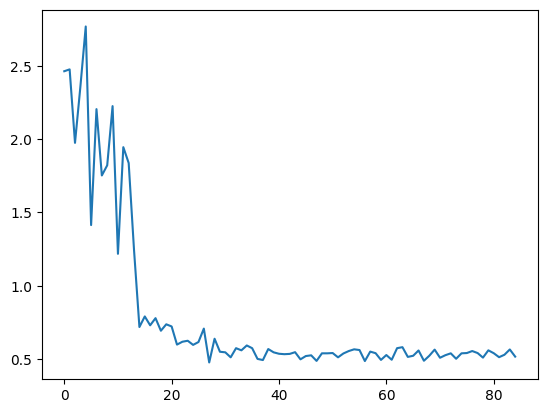

In [140]:
plt.plot(naive_cost_history_dict["cost_history"])

### Sampler

In [114]:
optimized_parity_ansatz = parity_ansatz_isa.assign_parameters(result_parity.x)

In [115]:
from qiskit_aer.primitives import SamplerV2 as AerSampler

sampler = AerSampler()
sampler.options.shots = 10000

parity_job = sampler.run([optimized_parity_ansatz])
parity_res = parity_job.result()

Parity approximation: 00110


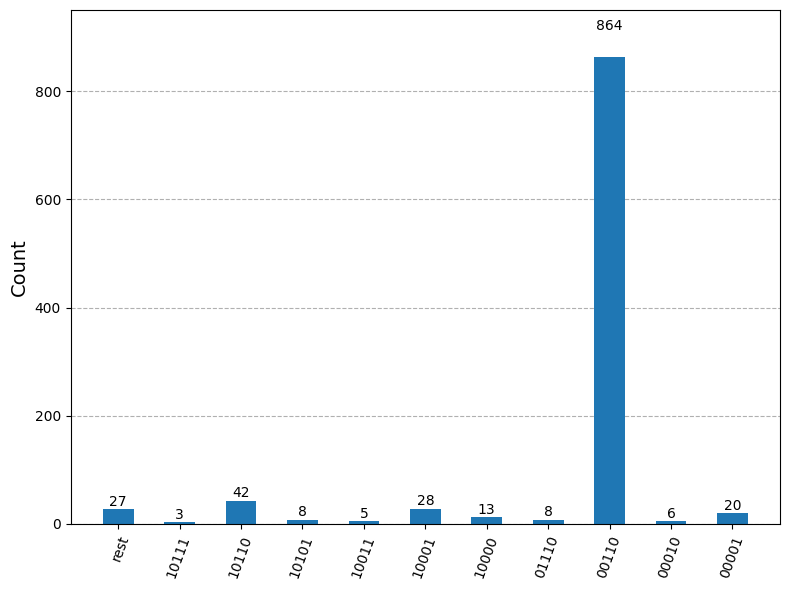

In [116]:
from qiskit.visualization import plot_histogram

counts = parity_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
parity_sol = most_likely_bitstring

print(f"Parity approximation: {parity_sol}")
plot_histogram(counts)
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))

In [141]:
optimized_naive_ansatz = parity_ansatz_isa.assign_parameters(result_naive.x)


Naive aproximation: 00110


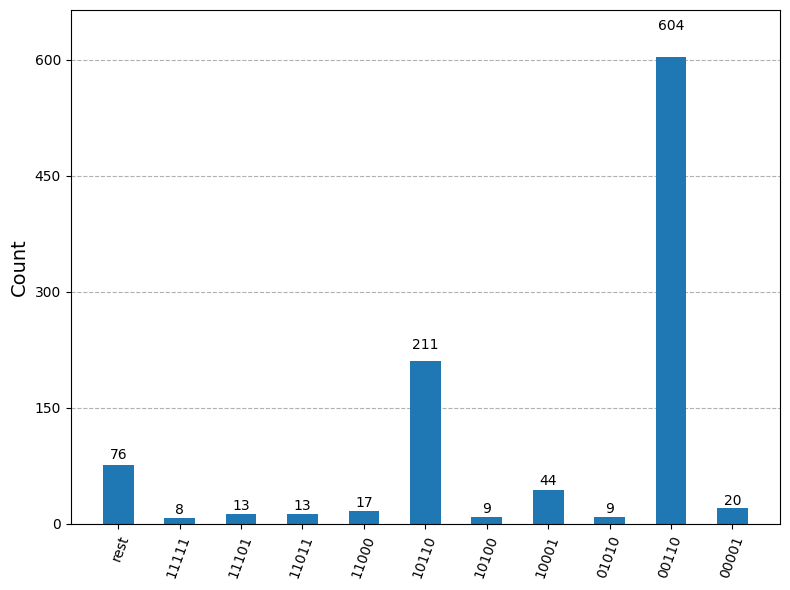

In [142]:
naive_job = sampler.run([optimized_naive_ansatz])
naive_res = naive_job.result()

counts = naive_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
naive_sol = most_likely_bitstring

print(f"\nNaive aproximation: {naive_sol}")
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))

### Noise AerSimulator

In [119]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

noisy_estimator = AerEstimator(
    options=dict(backend_options=dict(noise_model=noise_model))
)

In [120]:
noisy_parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [121]:
%%time

params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_parity_cost_history_dict)

result_noisy_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, noisy_estimator, noisy_parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 2.0048828125
Iters 2: Current cost: 2.2939453125
Iters 3: Current cost: 2.25390625
Iters 4: Current cost: 2.0126953125
Iters 5: Current cost: 1.9912109375
Iters 6: Current cost: 2.1103515625
Iters 7: Current cost: 2.20703125
Iters 8: Current cost: 1.99609375
Iters 9: Current cost: 2.2099609375
Iters 10: Current cost: 2.1875
Iters 11: Current cost: 1.943359375
Iters 12: Current cost: 2.080078125
Iters 13: Current cost: 2.1484375
Iters 14: Current cost: 2.0244140625
Iters 15: Current cost: 1.912109375
Iters 16: Current cost: 2.0283203125
Iters 17: Current cost: 1.9619140625
Iters 18: Current cost: 1.93359375
Iters 19: Current cost: 1.89453125
Iters 20: Current cost: 1.91796875
Iters 21: Current cost: 1.9541015625
Iters 22: Current cost: 1.9560546875
Iters 23: Current cost: 1.978515625
Iters 24: Current cost: 1.9091796875
Iters 25: Current cost: 1.921875
Iters 26: Current cost: 1.83203125
Iters 27: Current cost: 1.833984375
Iters 28: Current cost: 1.85546875
Iters 2

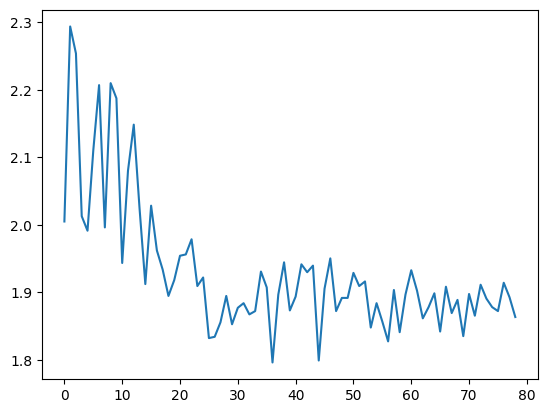

In [122]:
plt.plot(noisy_parity_cost_history_dict["cost_history"])

In [123]:
noisy_naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [152]:
%%time

params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_naive_cost_history_dict)

result_noisy_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, noisy_estimator, noisy_naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 2.01171875
Iters 2: Current cost: 2.0966796875
Iters 3: Current cost: 1.9873046875
Iters 4: Current cost: 2.0810546875
Iters 5: Current cost: 2.0126953125
Iters 6: Current cost: 2.029296875
Iters 7: Current cost: 2.0966796875
Iters 8: Current cost: 2.03125
Iters 9: Current cost: 2.0634765625
Iters 10: Current cost: 2.130859375
Iters 11: Current cost: 2.005859375
Iters 12: Current cost: 2.0341796875
Iters 13: Current cost: 2.048828125
Iters 14: Current cost: 2.046875
Iters 15: Current cost: 2.046875
Iters 16: Current cost: 2.041015625
Iters 17: Current cost: 2.068359375
Iters 18: Current cost: 2.037109375
Iters 19: Current cost: 2.0517578125
Iters 20: Current cost: 2.037109375
Iters 21: Current cost: 2.0244140625
Iters 22: Current cost: 2.056640625
Iters 23: Current cost: 2.015625
Iters 24: Current cost: 2.07421875
Iters 25: Current cost: 1.984375
Iters 26: Current cost: 1.984375
Iters 27: Current cost: 2.0556640625
Iters 28: Current cost: 2.060546875
Iters 29: Cu

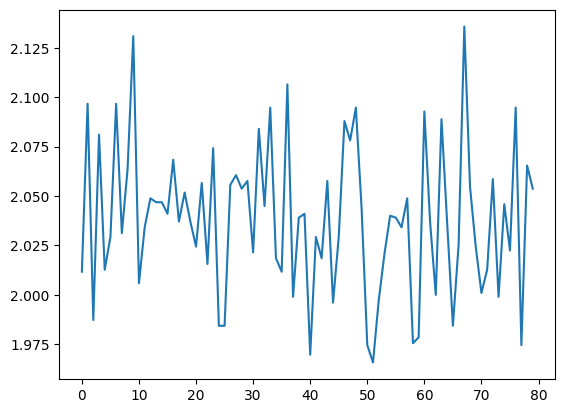

In [153]:
plt.plot(noisy_naive_cost_history_dict["cost_history"])

In [126]:
noisy_parity_ansatz_isa = parity_ansatz_isa
noisy_optimized_parity_ansatz = parity_ansatz_isa.assign_parameters(result_noisy_parity.x)


Nosiy parity approximation: 00110


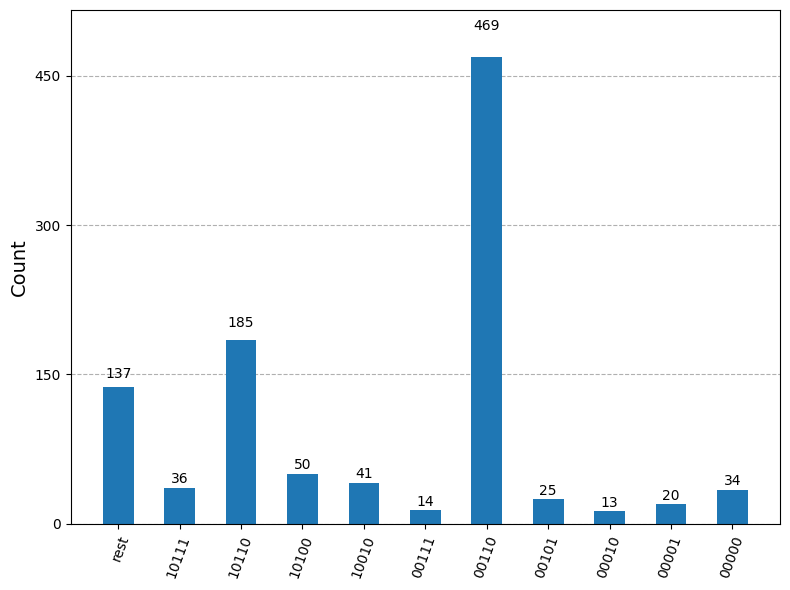

In [143]:
noisy_parity_job = sampler.run([noisy_optimized_parity_ansatz])
noisy_parity_res = noisy_parity_job.result()

counts = noisy_parity_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
noisy_parity_sol = most_likely_bitstring

print(f"\nNosiy parity approximation: {noisy_parity_sol}")
plot_histogram(counts)
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))

In [154]:
noisy_naive_ansatz_isa = naive_ansatz_isa
noisy_optimized_naive_ansatz = naive_ansatz_isa.assign_parameters(result_noisy_naive.x)


Nosiy naive approximation: 10110


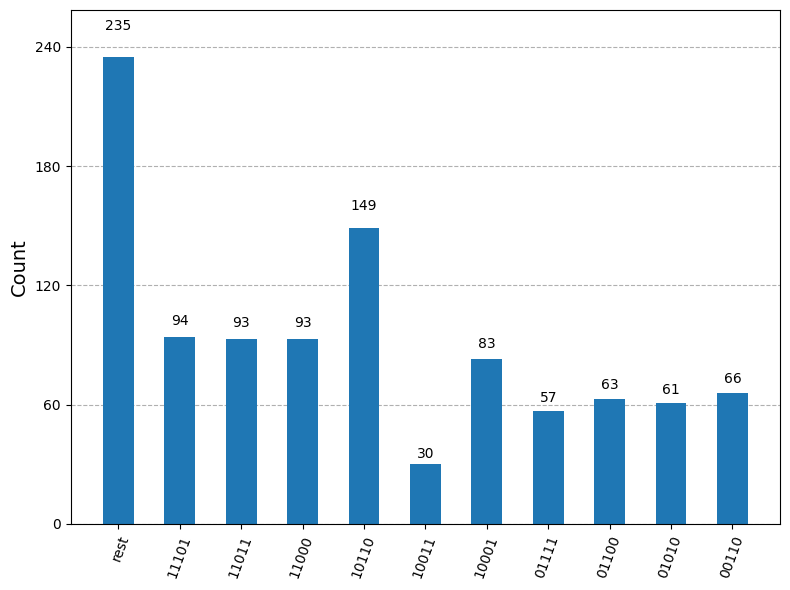

In [168]:
noisy_naive_job = sampler.run([noisy_optimized_naive_ansatz])
noisy_naive_res = noisy_naive_job.result()

counts = noisy_naive_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
noisy_naive_sol = most_likely_bitstring

print(f"\nNosiy naive approximation: {noisy_naive_sol}")
plot_histogram(counts)
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))